# YOLOv8n Object Detection Model Training - Adjunct Vessel Length Regressor

## 1. Setup

In [2]:
# Better error messages in notebooks
%load_ext autoreload
%autoreload 2

In [104]:
# Set up data paths
from pathlib import Path
import sys

# Get to project root from notebook location
PROJECT_ROOT = Path.cwd().parent
# Add "src" to Python's module search path sys.path
sys.path.append(str(PROJECT_ROOT / "src"))
sys.path.append("/home/peterm/UWA/CITS5014/SARFish/working")

# Define project paths
DATA_DIR = PROJECT_ROOT / "data"
CONFIG_DIR = PROJECT_ROOT / "configs"
RUNS_DIR = PROJECT_ROOT / "png_runs"

print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"DATA_DIR:     {DATA_DIR}")
print(f"CONFIG_DIR:   {CONFIG_DIR}")
print(f"RUNS_DIR:     {RUNS_DIR}")

PROJECT_ROOT: /home/peterm/UWA/CITS5014/SARFish/modelling
DATA_DIR:     /home/peterm/UWA/CITS5014/SARFish/modelling/data
CONFIG_DIR:   /home/peterm/UWA/CITS5014/SARFish/modelling/configs
RUNS_DIR:     /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs


In [111]:
# Complete SAR Dataset Conversion Script
#import os
#import numpy as np
#import pandas as pd
import cv2
import glob as glob
import yaml
import pickle
import matplotlib.pyplot as plt
from datetime import datetime
#from tqdm import tqdm
from ultralytics import YOLO
from plot_loss_curves import plot_total_loss
from match_png_vessel_lengths import build_image_vessel_length_table
from extract_features import extract_features
from vessel_length_regressor import  VesselLengthRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from utilities import *

## 2. Vessel detection model evaluation

The original 96 x 96 pixel training dataset was augmented as a way of addressing the problem of class imbalance in the data. Several geometric transforms (horizontal flip, vertical flip, 90, 180 and 270 degree anti-clockwise rotation and translation) were applied to the image crops in varying combination. In addition, composite images or 'mosaics' were  generated to expand the dataset even further. Augmentation was applied to the raw image crops prior to processing. The best performing pretrained YOLOv8n model configuration used to train the augmented and processed dataset is shown below. Note that 'in situ' augmentation or augmentation while training, was also applied.

### 2.1 Model configuration and training pipeline of 'best' performing model:

In [5]:
# Create data configuration
import yaml

data_config = {
    'path':   str(PROJECT_ROOT / 'data'), 
    'train':  'train_hvrt_msc_bal_alt',
    'val':    'val_alt', 
    'test':   'test_alt',
    'nc': 2,
    'names':  ['is_vessel', 'is_fishing']
}

# Save to configs directory
yaml_path = CONFIG_DIR / 'png_aug_bal.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(data_config, f)

In [6]:
# Load the model
model = YOLO('yolov8n.pt')

In [ ]:
# Create a timestamp for the training run
timestamp = datetime.now().strftime('%Y%m%d_%H%M')

# Train the model
results = model.train(
    data=str(yaml_path), 
    epochs=5, 
    batch=16, 
    imgsz=640,
    freeze=None,
    plots=True,
    project=RUNS_DIR / 'png_aug_bal',
    name=timestamp,
    
    # Optimization
    optimizer='SGD',      # explicit SGD
    lr0=0.01,             # initial learning rate
    lrf=0.01,             # final learning rate factor
    momentum=0.9,         # SGD momentum/Adam beta1
    weight_decay=0.0005,  # optimizer weight decay
    warmup_epochs=3.0,    # warmup epochs
    warmup_momentum=0.8,  # warmup momentum
    warmup_bias_lr=0.1,   # warmup bias lr
    
    
    # Augmentation parameters
    auto_augment=None, 
    hsv_h=0.0, 
    hsv_s=0.0, 
    hsv_v=0.0, 
    translate=0.1,  # transaltion (+/- fraction)
    degrees=15.0,   # rotation (+/- degrees)
    scale=0.0, 
    fliplr=0.5,     # horizontal flip (prob.)
    flipud=0.5,     # vertical flip (prob.)
    mosaic=1.0      # image mosaic (prob.)
)

Plot of total loss training and validaton curves:

In [7]:
results_path = RUNS_DIR / 'png_aug_bal' / '20250818_1835'

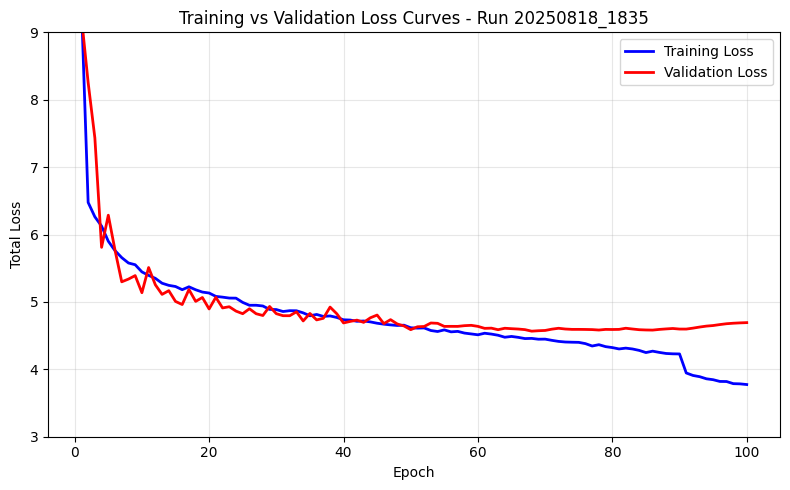

In [41]:
plot_total_loss(str(results_path / 'results.csv'), ylim=(3, 9))

### 2.2 Validation performance metrics (Ultralytics)

In [61]:
# Define best model path and check previously defined data path
model_path=results_path / 'weights' / 'best.pt'
print(model_path)
print(yaml_path)

/home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_aug_bal/20250818_1835/weights/best.pt
/home/peterm/UWA/CITS5014/SARFish/modelling/configs/png_aug_bal.yaml


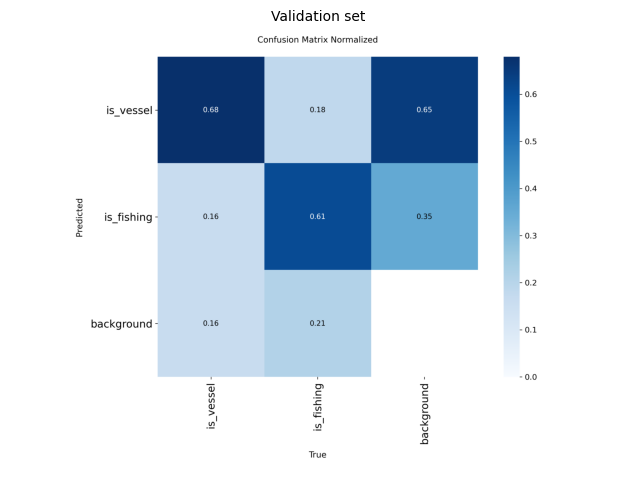

In [42]:
# Plot validataion set confusion matrix created during training
import matplotlib.image as mpimg

img_path = Path(results_path / 'confusion_matrix_normalized.png')
img = mpimg.imread(img_path)

plt.figure(figsize=(8, 6))  # Width x Height in inches
plt.imshow(img)
plt.axis('off')  # Optional: hides axis ticks
plt.title("Validation set", fontsize=10)  # Add a title with custom font size
plt.show()

Interpretation: 

**is_vessel class:** 68% correctly classified as vessels; 16% misclassified as fishing vessels; 16% misclassified as background or *no object detected*

**is_fishing class** 61% correctly classified as fishing vessels; 18% misclassified as general vessels; 21% misclassified as background or *no object detected*

**background class:** ????

Reproduce validation performance metrics:

In [55]:
# Load the model
model = YOLO(model_path)

# Run validation with Ultralytics defaults
results = model.val(
    data=yaml_path,  # data.yaml file from training
    split='val',
    conf=0.25,       # default Ultralytics validation!
    iou=0.7,         # Default UltralyticsNMS threshold
    verbose=True
)

Ultralytics 8.3.152 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 2000 Ada Generation Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 57.8±10.9 MB/s, size: 20.6 KB)


val: Scanning /home/peterm/UWA/CITS5014/SARFish/modelling/data/val_alt/labels.cache... 463 images, 0 backgrounds, 0 corr
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<


                   all        463        463      0.614      0.657      0.618      0.304
             is_vessel        331        331      0.736      0.692      0.764      0.395
            is_fishing        132        132      0.491      0.621      0.471      0.212
Speed: 0.6ms preprocess, 3.5ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/val6


The metrics are not identical but close to those recorded during training

In [56]:
# Retrive the confusion matrix (should be identical to training)
confusion_matrix = results.confusion_matrix.matrix

# Plot it
results.confusion_matrix.plot(
    save_dir='.' 
)

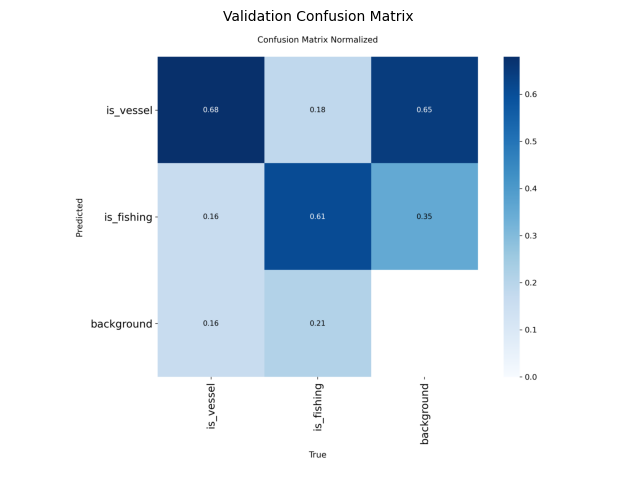

In [63]:
# Load and display the saved image
img_path = Path('confusion_matrix_normalized.png')
img = mpimg.imread(img_path)

plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis('off')
plt.title('Validation Confusion Matrix', fontsize=10)
plt.show()

### 2.3 Visualisation of validation predictions (Ultralytics)

In [7]:
# Function to show validation predictions saved during training.
def show_valid_results(RES_DIR):
    !ls {RES_DIR}
    EXP_PATH = f"{RES_DIR}"
    validation_pred_images = glob.glob(f"{EXP_PATH}/*_pred.jpg")
    print(validation_pred_images)
    for pred_image in validation_pred_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(15, 12))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

F1_curve.png					    train_batch1.jpg
PR_curve.png					    train_batch2.jpg
P_curve.png					    train_batch47250.jpg
R_curve.png					    train_batch47251.jpg
args.yaml					    train_batch47252.jpg
confusion_matrix.png				    val_batch0_labels.jpg
confusion_matrix_normalized.png			    val_batch0_pred.jpg
events.out.tfevents.1755513317.Phenom-II.1246327.1  val_batch1_labels.jpg
labels.jpg					    val_batch1_pred.jpg
labels_correlogram.jpg				    val_batch2_labels.jpg
results.csv					    val_batch2_pred.jpg
results.png					    weights
train_batch0.jpg
['/home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_aug_bal/20250818_1835/val_batch1_pred.jpg', '/home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_aug_bal/20250818_1835/val_batch0_pred.jpg', '/home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_aug_bal/20250818_1835/val_batch2_pred.jpg']


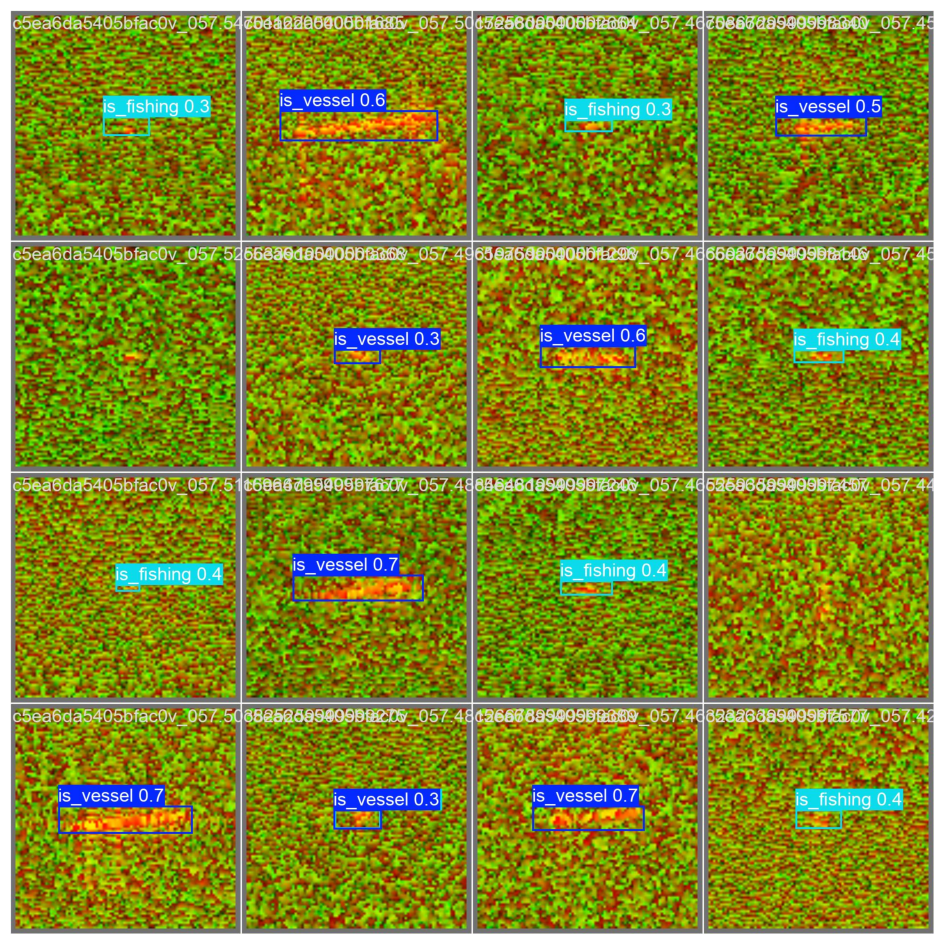

In [8]:
show_valid_results(results_path)

In [64]:
# Specify image val image directory
val_images_path = DATA_DIR / "val_alt" / "images"

In [83]:
from compare_validation_predictions import create_sar_prediction_comparison

model = YOLO(model_path)
create_sar_prediction_comparison(model, val_images_path, num_images=6)

Found 463 images. Displaying 6 randomly selected images:



## 3. Vessel Length Regression

### 3.1 Data preparation

Data preparation involves a two-step procedure:

1. Given a dateset comprising processed SAR SLC image crops in PNG format, construct a look-up table with the name of each image file and the ground truth vessel length of the detected object or objects within that image, if available.
2. Loop through each image, predict the object(s) using the trained detection model and extract the prediction "features" (i.e., predicted bounding box width, height, confidence and class) and append the corresponding ground truth vessel length from the look-up table and save the extracted features.

#### 3.1.1 Training set

In [222]:
# Construct a table comprising image filename and vessel_length
build_image_vessel_length_table(input_csv_path='/home/peterm/UWA/CITS5014/SARFish/working/df_labels_train_filt.csv',
                                       png_dir='/home/peterm/UWA/CITS5014/SARFish/working/train/crops_png_alt/images_hvrt_msc_bal',
                               output_csv_path='/home/peterm/UWA/CITS5014/SARFish/working/hvrt_msc_bal_vlen.csv',
                                       logfile='/home/peterm/UWA/CITS5014/SARFish/working/hvrt_msc_bal_vlen.log')

Loaded 3139 records from CSV
Created lookup dictionary with 3139 entries
Found 8396 .png files
Successfully matched 8293/8293 files
Files with NaN vessel lengths: 0
Unparsed files: 0
Skipped mosaic files: 70
Output saved to /home/peterm/UWA/CITS5014/SARFish/working/hvrt_msc_bal_vlen.csv


In [223]:
# Print basic stats for the lookup table just created
train_vlen_lookup_summary = summarise_csv('../../working/hvrt_msc_bal_vlen.csv')
print(train_vlen_lookup_summary)

                   dtype  count  missing   min    max
filename          object   8293        0   NaN    NaN
vessel_length_m  float64   8293        0  6.96  343.4


In [224]:
# Define inputs
model_path = results_path / 'weights' / 'best.pt'  # should be from run 20250818_1835
metadata_path = '/home/peterm/UWA/CITS5014/SARFish/working/hvrt_msc_bal_vlen.csv'
image_dir = '/home/peterm/UWA/CITS5014/SARFish/working/train/crops_png_alt/images_hvrt_msc_bal'
file_ext = '.png'
output_csv = '/home/peterm/UWA/CITS5014/SARFish/working/hvrt_msc_bal_vlen_reg_input.csv'

# Run the function to extract features
extract_features(model_path, metadata_path, image_dir, file_ext, output_csv)

100%|███████████████████████████████████████████████████████████████████████████████| 8396/8396 [23:23<00:00,  5.98it/s]

Saved 7536 records to /home/peterm/UWA/CITS5014/SARFish/working/hvrt_msc_bal_vlen_reg_input.csv


In [225]:
# Print basic stats for the lookup table just created
train_vlen_lookup_summary = summarise_csv('../../working/hvrt_msc_bal_vlen_reg_input.csv')
print(train_vlen_lookup_summary)

          dtype  count  missing       min         max
class     int64   7536        0  0.000000    1.000000
conf    float64   7536        0  0.250026    0.885401
height  float64   7536        0  1.922867   70.698470
image    object   7536        0       NaN         NaN
length  float64   7536        0  6.960000  343.400000
width   float64   7536        0  2.283745   95.330475


#### 3.1.2 Validation set

Repeat the two-step procedure in Section 3.1.1 for the `val` set if necessary (e.g. if PNG dataset crop size is varied).

In [226]:
# Construct a table comprising image filename and vessel_length
build_image_vessel_length_table(input_csv_path='/home/peterm/UWA/CITS5014/SARFish/working/df_labels_val_filt.csv',
                                       png_dir='/home/peterm/UWA/CITS5014/SARFish/working/val/crops_png_alt/images',
                               output_csv_path='/home/peterm/UWA/CITS5014/SARFish/working/val_vlen.csv',
                                       logfile='/home/peterm/UWA/CITS5014/SARFish/working/val_vlen.log')

Loaded 464 records from CSV
Created lookup dictionary with 464 entries
Found 463 .png files
Successfully matched 459/459 files
Files with NaN vessel lengths: 0
Unparsed files: 0
Skipped mosaic files: 0
Output saved to /home/peterm/UWA/CITS5014/SARFish/working/val_vlen.csv


In [229]:
# Print basic stats for the lookup table just created
val_vlen_lookup_summary = summarise_csv('../../working/val_vlen.csv')
print(val_vlen_lookup_summary)

                   dtype  count  missing   min         max
filename          object    459        0   NaN         NaN
vessel_length_m  float64    459        0  9.99  240.168797


In [230]:
# Define inputs
model_path = results_path / 'weights' / 'best.pt'  # should be from run 20250818_1835
metadata_path = '/home/peterm/UWA/CITS5014/SARFish/working/val_vlen.csv'
image_dir = '/home/peterm/UWA/CITS5014/SARFish/working/val/crops_png_alt/images'
file_ext = '.png'
output_csv = '/home/peterm/UWA/CITS5014/SARFish/working/val_vlen_reg_input.csv'

# Run the function to extract features
extract_features(model_path, metadata_path, image_dir, file_ext, output_csv)

100%|█████████████████████████████████████████████████████████████████████████████████| 463/463 [00:36<00:00, 12.72it/s]

Saved 296 records to /home/peterm/UWA/CITS5014/SARFish/working/val_vlen_reg_input.csv


In [231]:
# Print basic stats for the lookup table just created
val_vlen_lookup_summary = summarise_csv('../../working/val_vlen_reg_input.csv')
print(val_vlen_lookup_summary)

          dtype  count  missing        min         max
class     int64    296        0   0.000000    1.000000
conf    float64    296        0   0.250435    0.726181
height  float64    296        0   3.091972   36.254776
image    object    296        0        NaN         NaN
length  float64    296        0  10.200000  240.168797
width   float64    296        0   9.780499   90.343666


#### 3.1.3 Test set

Repeat the two-step procedure in Section 3.1.1 for the `test` set if necessary (e.g. if PNG dataset crop size is varied).

In [232]:
# Construct a table comprising image filename and vessel_length
build_image_vessel_length_table(input_csv_path='/home/peterm/UWA/CITS5014/SARFish/working/df_labels_test_filt.csv',
                                       png_dir='/home/peterm/UWA/CITS5014/SARFish/working/test/crops_png_alt/images',
                               output_csv_path='/home/peterm/UWA/CITS5014/SARFish/working/test_vlen.csv',
                                       logfile='/home/peterm/UWA/CITS5014/SARFish/working/test_vlen.log')

Loaded 254 records from CSV
Created lookup dictionary with 254 entries
Found 253 .png files
Successfully matched 248/248 files
Files with NaN vessel lengths: 0
Unparsed files: 0
Skipped mosaic files: 0
Output saved to /home/peterm/UWA/CITS5014/SARFish/working/test_vlen.csv


In [233]:
# Print basic stats for the lookup table just created
test_vlen_lookup_summary = summarise_csv('../../working/test_vlen.csv')
print(test_vlen_lookup_summary)

                   dtype  count  missing        min         max
filename          object    248        0        NaN         NaN
vessel_length_m  float64    248        0  12.299578  274.397788


In [235]:
# Define inputs
model_path = results_path / 'weights' / 'best.pt'  # should be from run 20250818_1835
metadata_path = '/home/peterm/UWA/CITS5014/SARFish/working/test_vlen.csv'
image_dir = '/home/peterm/UWA/CITS5014/SARFish/working/test/crops_png_alt/images'
file_ext = '.png'
output_csv = '/home/peterm/UWA/CITS5014/SARFish/working/test_vlen_reg_input.csv'

# Run the function to extract features
extract_features(model_path, metadata_path, image_dir, file_ext, output_csv)

100%|█████████████████████████████████████████████████████████████████████████████████| 253/253 [00:13<00:00, 19.07it/s]

Saved 193 records to /home/peterm/UWA/CITS5014/SARFish/working/test_vlen_reg_input.csv


In [236]:
# Print basic stats for the lookup table just created
test_vlen_lookup_summary = summarise_csv('../../working/test_vlen_reg_input.csv')
print(test_vlen_lookup_summary)

          dtype  count  missing        min         max
class     int64    193        0   0.000000    1.000000
conf    float64    193        0   0.250252    0.680331
height  float64    193        0   3.162682   30.542004
image    object    193        0        NaN         NaN
length  float64    193        0  13.369143  255.602511
width   float64    193        0  11.066586   86.898220


### 3.2 Train a regression model. 

Use the "features" extracted from the train, val and test sets as inputs to train a RandomForest Regressor.

In [365]:
# Instantiate a regressor with the best parameter values determined above
regressor = VesselLengthRegressor(model_params={'max_depth': 10, 
                                                'min_samples_leaf': 5, 
                                                'min_samples_split': 2, 
                                                'n_estimators': 413,
                                                'n_jobs': 1,
                                                'random_state': 42}, 
                                  feature_cols=['width', 'height', 'class'])

In [366]:
#regressor = VesselLengthRegressor(feature_cols=['width', 'height', 'class'])

In [367]:
# Load and prepare the data

train_csv='/home/peterm/UWA/CITS5014/SARFish/working/hvrt_msc_bal_vlen_reg_input.csv'
val_csv='/home/peterm/UWA/CITS5014/SARFish/working/val_vlen_reg_input.csv'
test_csv='/home/peterm/UWA/CITS5014/SARFish/working/test_vlen_reg_input.csv'

X_train, y_train, X_val, y_val, X_test, y_test = regressor.load_and_prepare_data(train_csv, val_csv, test_csv)

In [368]:
# Check shapes of data splits
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, {y_val.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")

Training data shape: (7536, 3), (7536,)
Validation data shape: (296, 3), (296,)
Test data shape: (193, 3), (193,)


```python
# Perform a randomized search for the best parameter values for the nominated parameters

param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': [None] + list(range(5, 20)),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10)
}

rf = RandomForestRegressor()
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions, cv=5, n_iter=10, random_state=None)
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)
```

In [369]:
# Train the regressor
model = regressor.train_regressor(X_train, y_train)
print("Model training completed!")
print(f"Feature importances: { {col: f'{imp:.3f}' for col, imp in zip(regressor.feature_cols, model.feature_importances_)} }")

Model training completed!
Feature importances: {'width': '0.421', 'height': '0.111', 'class': '0.468'}


In [370]:
# Make predictions
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

In [371]:
# Calculate and display metrics
train_metrics = regressor.calculate_metrics(y_train, y_train_pred)
val_metrics = regressor.calculate_metrics(y_val, y_val_pred)
test_metrics = regressor.calculate_metrics(y_test, y_test_pred)
print("=== Performance Metrics ===")
print(f"Train - MAE: {train_metrics['mae']:.2f}, RMSE: {train_metrics['rmse']:.2f}, R²: {train_metrics['r2']:.3f}, VLA: {train_metrics['vla']:.3f}")
print(f"Val   - MAE: {val_metrics['mae']:.2f}, RMSE: {val_metrics['rmse']:.2f}, R²: {val_metrics['r2']:.3f}, VLA: {val_metrics['vla']:.3f}")
print(f"Test  - MAE: {test_metrics['mae']:.2f}, RMSE: {test_metrics['rmse']:.2f}, R²: {test_metrics['r2']:.3f}, VLA: {test_metrics['vla']:.3f}")

=== Performance Metrics ===
Train - MAE: 13.39, RMSE: 22.21, R²: 0.831, VLA: 0.709
Val   - MAE: 20.48, RMSE: 30.38, R²: 0.708, VLA: 0.688
Test  - MAE: 23.77, RMSE: 33.63, R²: 0.667, VLA: 0.604


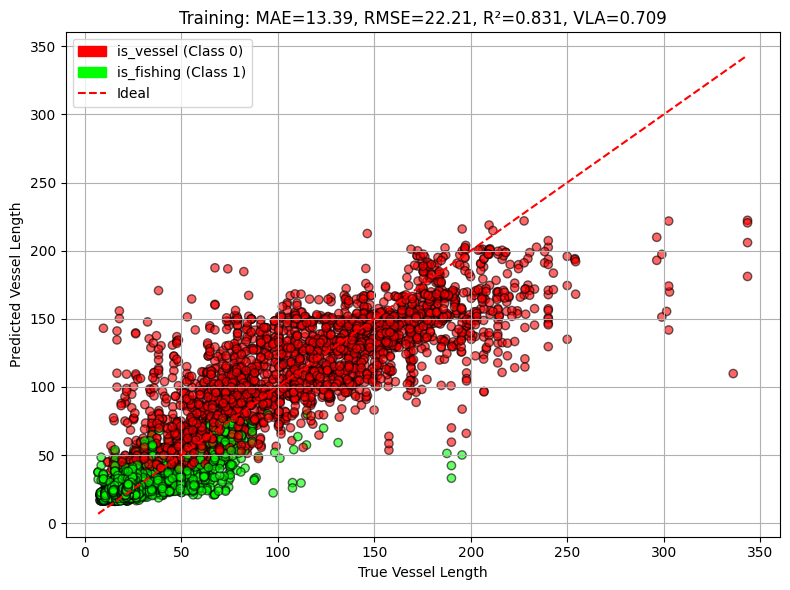

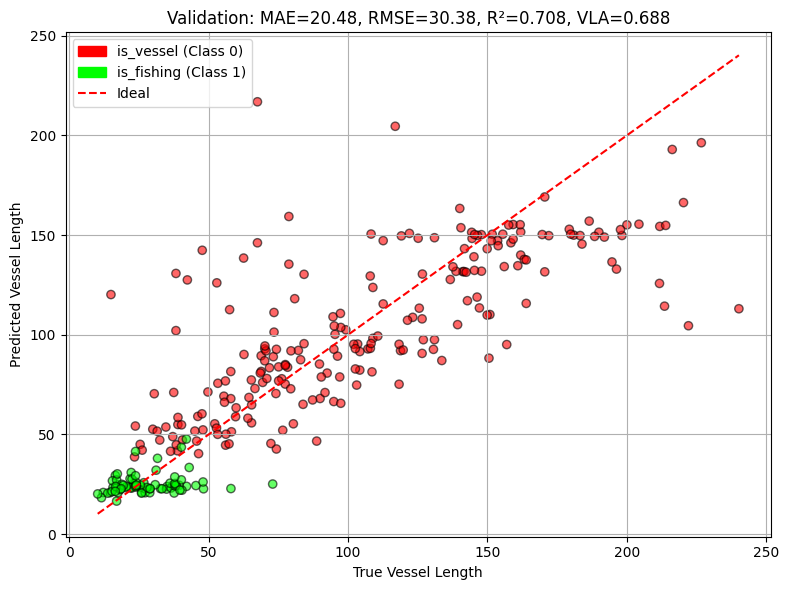

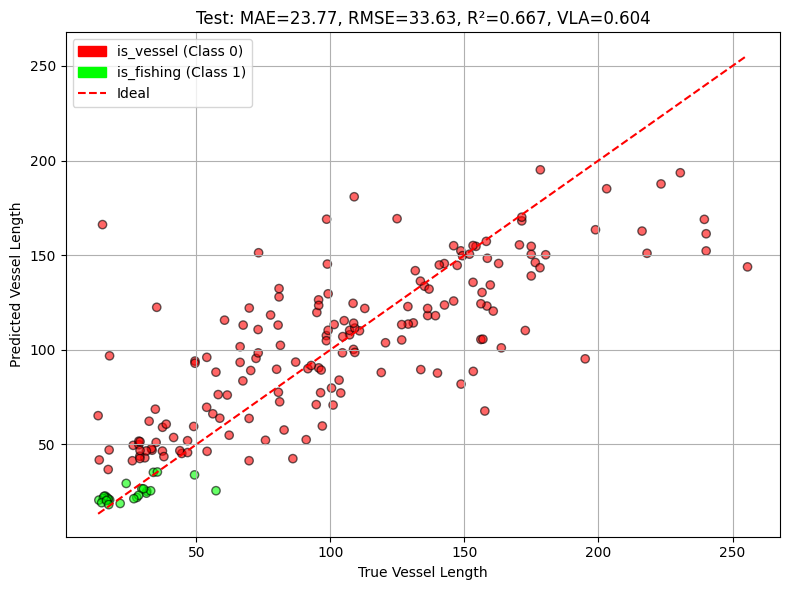

In [372]:
# Create visualisations
# Extract class information for colored plotting (if 'class' is in features)
train_classes = X_train[:, regressor.feature_cols.index('class')] if 'class' in regressor.feature_cols else None
val_classes = X_val[:, regressor.feature_cols.index('class')] if 'class' in regressor.feature_cols else None
test_classes = X_test[:, regressor.feature_cols.index('class')] if 'class' in regressor.feature_cols else None
# Prepare plot data dictionary
plot_data = {
    'train_true': y_train,
    'train_pred': y_train_pred,
    'val_true': y_val,
    'val_pred': y_val_pred,
    'test_true': y_test,
    'test_pred': y_test_pred,
    'train_metrics': train_metrics,
    'val_metrics': val_metrics,
    'test_metrics': test_metrics,
    'train_classes': train_classes,
    'val_classes': val_classes,
    'test_classes': test_classes
}
# Gemerate all plots
regressor.plot_results(plot_data)

Save the model if required:

In [374]:
# Generate timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M')

# Define log directory and save path
log_dir=f"/home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/vessel_length/{timestamp}"
save_path = 'vessel_length_model.pkl'

# Save the model
model_save_path = regressor.save_model(save_path, log_dir)

Regressor saved to /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/vessel_length/20250828_2200/vessel_length_model.pkl


In [260]:
def calculate_metrics_by_class(regressor, y_true, y_pred, classes, split_name=""):
  """
  Calculate metrics separately for each class.
  
  Args:
      regressor: VesselLengthRegressor instance  
      y_true: True values
      y_pred: Predicted values
      classes: Class labels (0=vessel, 1=fishing)
      split_name: Name for printing (e.g., "Train", "Val", "Test")
  
  Returns:
      Dictionary with overall and per-class metrics
  """
  # Overall metrics
  overall_metrics = regressor.calculate_metrics(y_true, y_pred)

  # Initialize results
  results = {
      'overall': overall_metrics,
      'by_class': {}
  }

  # Calculate metrics for each class
  unique_classes = np.unique(classes)
  class_names = {0: 'is_vessel', 1: 'is_fishing'}

  for cls in unique_classes:
      mask = classes == cls
      if np.sum(mask) > 0:  # Check if class has samples
          cls_metrics = regressor.calculate_metrics(y_true[mask], y_pred[mask])
          cls_metrics['n_samples'] = np.sum(mask)
          results['by_class'][int(cls)] = cls_metrics

  # Print formatted results
  if split_name:
      print(f"\n=== {split_name} Metrics ===")
      print(f"Overall: MAE = {overall_metrics['mae']:.2f}, RMSE = {overall_metrics['rmse']:.2f}, R² = {overall_metrics['r2']:.3f}")

      for cls, metrics in results['by_class'].items():
          cls_name = class_names.get(cls, f"Class_{cls}")
          print(f"{cls_name}: MAE = {metrics['mae']:.2f}, RMSE = {metrics['rmse']:.2f}, R² = {metrics['r2']:.3f} (n = {metrics['n_samples']})")

  return results


In [375]:
if 'class' in regressor.feature_cols:
    class_idx = regressor.feature_cols.index('class')
    train_results = calculate_metrics_by_class(regressor, y_train, y_train_pred,X_train[:, class_idx], "Training")
    val_results = calculate_metrics_by_class(regressor, y_val, y_val_pred,X_val[:, class_idx], "Validation")
    test_results = calculate_metrics_by_class(regressor, y_test, y_test_pred,X_test[:, class_idx], "Test")
else:
    print("No 'class' feature found - showing overall metrics only")


=== Training Metrics ===
Overall: MAE = 13.39, RMSE = 22.21, R² = 0.831
is_vessel: MAE = 24.11, RMSE = 33.30, R² = 0.638 (n = 2863)
is_fishing: MAE = 6.82, RMSE = 10.79, R² = 0.514 (n = 4673)

=== Validation Metrics ===
Overall: MAE = 20.48, RMSE = 30.38, R² = 0.708
is_vessel: MAE = 24.51, RMSE = 34.60, R² = 0.544 (n = 219)
is_fishing: MAE = 9.03, RMSE = 11.91, R² = -0.089 (n = 77)

=== Test Metrics ===
Overall: MAE = 23.77, RMSE = 33.63, R² = 0.667
is_vessel: MAE = 26.39, RMSE = 35.89, R² = 0.579 (n = 168)
is_fishing: MAE = 6.14, RMSE = 8.56, R² = 0.375 (n = 25)
